In [1]:
import torch
import numpy as np

from torch import nn as nn
from torch.nn import functional as F
from torch.autograd import Variable, Function
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
import torch.nn.functional as F

import os

from tqdm import tqdm, tqdm_notebook
from tensorboardX import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from deep_wiener.utils import *
from deep_wiener.modules import *

In [3]:
data = microcells(folder='../../dsbowl/train/', kernels='../kernels/1d_div/')

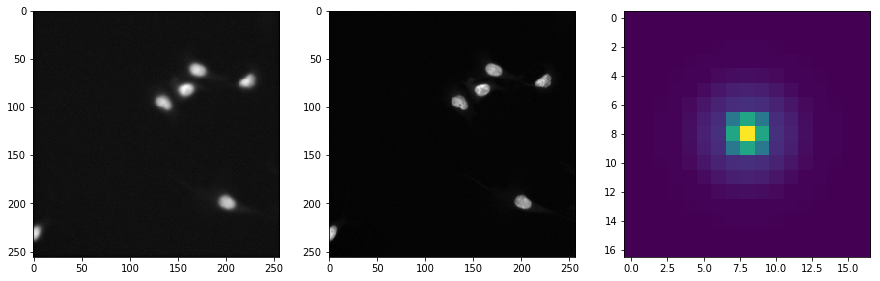

In [4]:
b,g,p = data[np.random.randint(len(data))]
fig, ax = plt.subplots(1,3, figsize=(15,7))
ax[0].imshow(b[0,:,:,0], cmap='gray')
ax[1].imshow(g[0,:,:,0], cmap='gray')
ax[2].imshow(p[0]);

In [5]:
data_train =torch.utils.data.DataLoader(data, batch_size=16, shuffle=True, drop_last=True)
data_test = microcells(folder='../../dsbowl/train/', kernels='../kernels/1d_div/', crop=False)

### Net:

In [6]:
net = Wiener_dec(filter_dim=(7,7), num_filters=48, init_alpha=-3)
criterion = nn.L1Loss()#nn.L1Loss(reduction='sum')
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

In [7]:
def train(net, criterion, opt, epoches, train_feeder, test_feeder, log_dir=None):
    
    if not log_dir is None:
        writer = SummaryWriter(log_dir)
        
    losses, val_psnrs_lum, var_psnr = [], [], []
    c=0

    for epoch in tqdm(range(epoches)):

        net.train(True)
        for j, (corr, target, psfs) in tqdm_notebook(enumerate(train_feeder)):
            corr_y = corr[...,0]
            target_y = target[...,0]

            restored = net(corr_y, psfs)
            loss = criterion(restored, target_y)

            losses.append(loss.item())

            if c%2==0 and not log_dir is None:
                writer.add_scalar('Loss', loss.item(), global_step=c)
            c+=1

            net.zero_grad()
            loss.backward()
            opt.step()

        #validate
        net.train(False)
        net.eval()

        curr_psnr_lum = []
        curr_psnr = []
        print('validating...')
        for i in range(99):

            vcorr, vtarget, vpsfs = test_feeder[i]
            vcorr, vtarget, vpsfs = vcorr[None,...], vtarget[None,...], vpsfs[None,...]
            vcorr_y, vtarget_y = vcorr[...,0], vtarget[...,0]

            vrestored = net(vcorr_y, vpsfs)

            vrestored_num = vrestored.data[0,0].numpy()
            curr_psnr_lum.append(compare_psnr(vrestored_num, vtarget_y[0,0].numpy()))

        if not log_dir is None:
            writer.add_image('Restored', vrestored, epoch)

        if epoch == 0 and not log_dir is None:
            writer.add_image('GT', vtarget_y, epoch)
            writer.add_image('Corrupted', vcorr_y, epoch)

        val_psnrs_lum.append(np.mean(curr_psnr_lum))

        if not log_dir is None:
            writer.add_scalar('Val_PSNR_lum', val_psnrs_lum[-1], global_step=epoch)
        
    return net

In [ ]:
net = train(net, criterion, opt, epoches=50, train_feeder=data_train, test_feeder=data_test,
            log_dir = '../experiments/exp2')

  0%|          | 0/50 [00:00<?, ?it/s]

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


validating...
sd2
sd3


  2%|▏         | 1/50 [03:57<3:14:15, 237.87s/it]

sd4


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


validating...


  4%|▍         | 2/50 [08:01<3:12:25, 240.52s/it]

sd2
sd4


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


validating...


  6%|▌         | 3/50 [12:04<3:09:16, 241.63s/it]

sd2
sd4


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))